# Tutorial for QA of Skull Strip

This tutorial is designed to illustrate the QA code used to generate the figure for the stripped brain and skull.

This code will do 3 main things:

1. Input original t1w file and the skull-striped brain file
2. Shows the skull-stripped brain (green) overlaid on the original t1w (magenta)
3. save the image into output directory

So that we can open the QA image to see if the skull strip result is good or not.

## Import packages

qa_skullstrip uses libraries and functions from nibabel, numpy, and m2g

In [2]:
#import packages
import warnings

warnings.simplefilter("ignore")
import sys
import nibabel as nib
import numpy as np
import os
from PIL import Image, ImageDraw,ImageFont
import matplotlib.pyplot as plt
from m2g.stats.qa_skullstrip import gen_overlay_pngs

## gen_overlay_pngs

The skullstrip qa images are created using the function gen_overlay_pngs, which will call the function plot_overlays_skullstrip

In [6]:
def gen_overlay_pngs(
    brain, original, outdir, loc=0, mean=False, minthr=2, maxthr=95, edge=False):
    """Generate a QA image for skullstrip.
    will call the function plot_overlays_skullstrip

    Parameters
    ----------
    brain: nifti file
        Path to the skull-stripped nifti brain
    original: nifti file
        Path to the original t1w brain, with the skull included
    outdir: str
        Path to the directory where QA will be saved
    loc: int
        which dimension of the 4d brain data to use
    mean: bool
        whether to calculate the mean of the 4d brain data
        If False, the loc=0 dimension of the data (mri_data[:, :, :, loc]) is used
    minthr: int
        lower percentile threshold
    maxthr: int
        upper percentile threshold
    edge: bool
        whether to use normalized luminance data
        If None, the respective min and max of the color array is used.
    """
    original_name = get_filename(original)
    brain_data = nb.load(brain).get_data()
    if brain_data.ndim == 4:  # 4d data, so we need to reduce a dimension
        if mean:
            brain_data = brain_data.mean(axis=3)
        else:
            brain_data = brain_data[:, :, :, loc]

    fig = plot_overlays_skullstrip(brain_data, original)

    # name and save the file
    fig.savefig(f"{outdir}/qa_skullstrip__{original_name}.png", format="png")


## plot_overlays_skullstrip

Skull-strip qa calls plot_overlays_skullstrip which shows the skull-stripped brain (green) overlaid on the original t1w (magenta)

In [5]:
def plot_overlays_skullstrip(brain, original, cmaps=None, minthr=2, maxthr=95, edge=False):
    """Shows the skull-stripped brain (green) overlaid on the original t1w (magenta)

    Parameter
    ---------
    brain: str, nifti image, numpy.ndarray
        an object to open the data for a skull-stripped brain. Can be a string (path to a brain file),
        nibabel.nifti1.nifti1image, or a numpy.ndarray.
    original: str, nifti image, numpy.ndarray
        an object to open the data for t1w brain, with the skull included. Can be a string (path to a brain file),
        nibabel.nifti1.nifti1image, or a numpy.ndarray.
    cmaps: matplotlib colormap objects
        colormap objects based on lookup tables using linear segments.
    minthr: int
        lower percentile threshold
    maxthr: int
        upper percentile threshold
    edge: bool
        whether to use normalized luminance data
        If None, the respective min and max of the color array is used.

    Returns
    ---------
    foverlay: matplotlib.figure.Figure

    """

    plt.rcParams.update({"axes.labelsize": "x-large", "axes.titlesize": "x-large"})
    foverlay = plt.figure()

    original = get_braindata(original)
    brain_shape = get_braindata(brain).shape
    brain = get_braindata(brain)
    if original.shape != brain.shape:
        raise ValueError("Two files are not the same shape.")
    brain = pad_im(brain, max(brain_shape[0:3]), pad_val=0, rgb=False)
    original = pad_im(original,max(brain_shape[0:3]), pad_val=0, rgb=False)


    if cmaps is None:
        cmap1 = LinearSegmentedColormap.from_list("mycmap1", ["white", "magenta"])
        cmap2 = LinearSegmentedColormap.from_list("mycmap2", ["white", "green"])
        cmaps = [cmap1, cmap2]

    x, y, z = get_true_volume(brain)
    coords = (x, y, z)

    labs = [
        "Sagittal Slice",
        "Coronal Slice",
        "Axial Slice",
    ]
    var = ["X", "Y", "Z"]
    # create subplot for first slice
    # and customize all labels
    idx = 0
    if edge:
        min_val = 0
        max_val = 1
    else:
        min_val, max_val = get_min_max(brain, minthr, maxthr)

    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = foverlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(brain[pos, :, :], 90)
                atl = ndimage.rotate(original[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(brain[:, pos, :], 90)
                atl = ndimage.rotate(original[:, pos, :], 90)
            else:
                image = ndimage.rotate(brain[:, :, pos], 0)
                atl = ndimage.rotate(original[:, :, pos], 0)

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0] / 2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1] / 2, image.shape[1] - 1])
            if edge:
                image = edge_map(image).data
                image[image > 0] = max_val
                image[image == 0] = min_val
            # Set the axis invisible
            plt.xticks([])
            plt.yticks([])

            # Set the frame invisible
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.imshow(atl, interpolation="none", cmap=cmaps[0], alpha=0.9)
            ax.imshow(
                opaque_colorscale(
                    cmaps[1], image, alpha=0.9, vmin=min_val, vmax=max_val
                )
            )
            if idx ==3:
                plt.plot(0, 0, "-", c="magenta", label='skull')
                plt.plot(0, 0, "-", c="green", label='brain')
                # box = ax.get_position()
                # ax.set_position([box.x0, box.y0, box.width, box.height*0.8])
                plt.legend(loc='best', fontsize=15, frameon=False, bbox_to_anchor=(1.5, 1.5))

    # Set title for the whole picture
    a, b, c = brain_shape
    title = 'Skullstrip QA. Scan Volume : ' + str(a) + '*' + str(b) + '*' + str(c)
    foverlay.suptitle(title, fontsize=24)
    foverlay.set_size_inches(12.5, 10.5, forward=True)
    return foverlay

## Inputs

original is the path to the original t1w brain, with the skull included

outdir is the path to the directory where QA image will be saved

you can change it to your own path

In [8]:
original = r'/mnt/f/JHU/ndd/dataset/part_of_SWU4/sub-0025629_ses-1_T1w.nii.gz'
outdir  = r'/mnt/f/JHU/ndd/dataset/output1/sub-0025864/ses-1/'

## Run AFNI 3dSkullStrip to do skull strip

Use AFNI 3dSkullStrip to do skull strip for the original t1w brain

In [ ]:
brainfile = f"{outdir}only_brain.nii.gz"
cmd = f"3dSkullStrip -prefix {brainfile} -input {original} -ld 30"
os.system(cmd)

## Run qa_skullstrip.py

Call the function gen_overlay_pngs

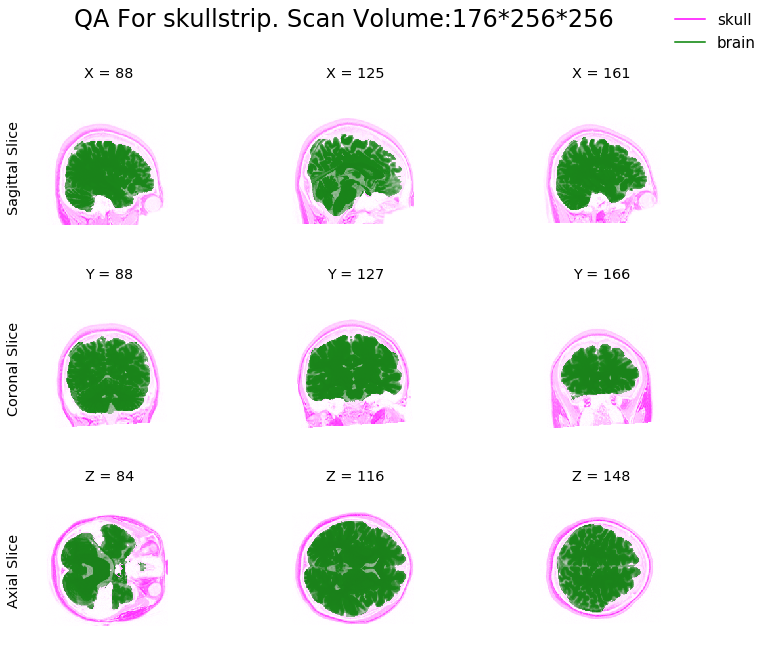

In [7]:
%matplotlib inline
gen_overlay_pngs(brainfile, original,outdir, loc=0, mean=False, minthr=2, maxthr=95, edge=False)

The QA image is shown above. The green is the brain and the magenta is the original scan.
Upon visual inspection along the edges you can observe the quality of the skull stripping process by observing if (a) there is skull remaining and (b) if there is too much brain removed when comparing the green to the magenta.

## Notice

Don't miss the order of parameter when calling gen_overlay_pngs. If you miss this order, both skull and brain will be green.

When calling gen_overlay_pngs, barinfile and original should be the path of skull-stripped brain and original t1w file.